# LABORATORY SESSION - WEEK 6

### Exercise 1

Implement BA algorithm.

### Solution 

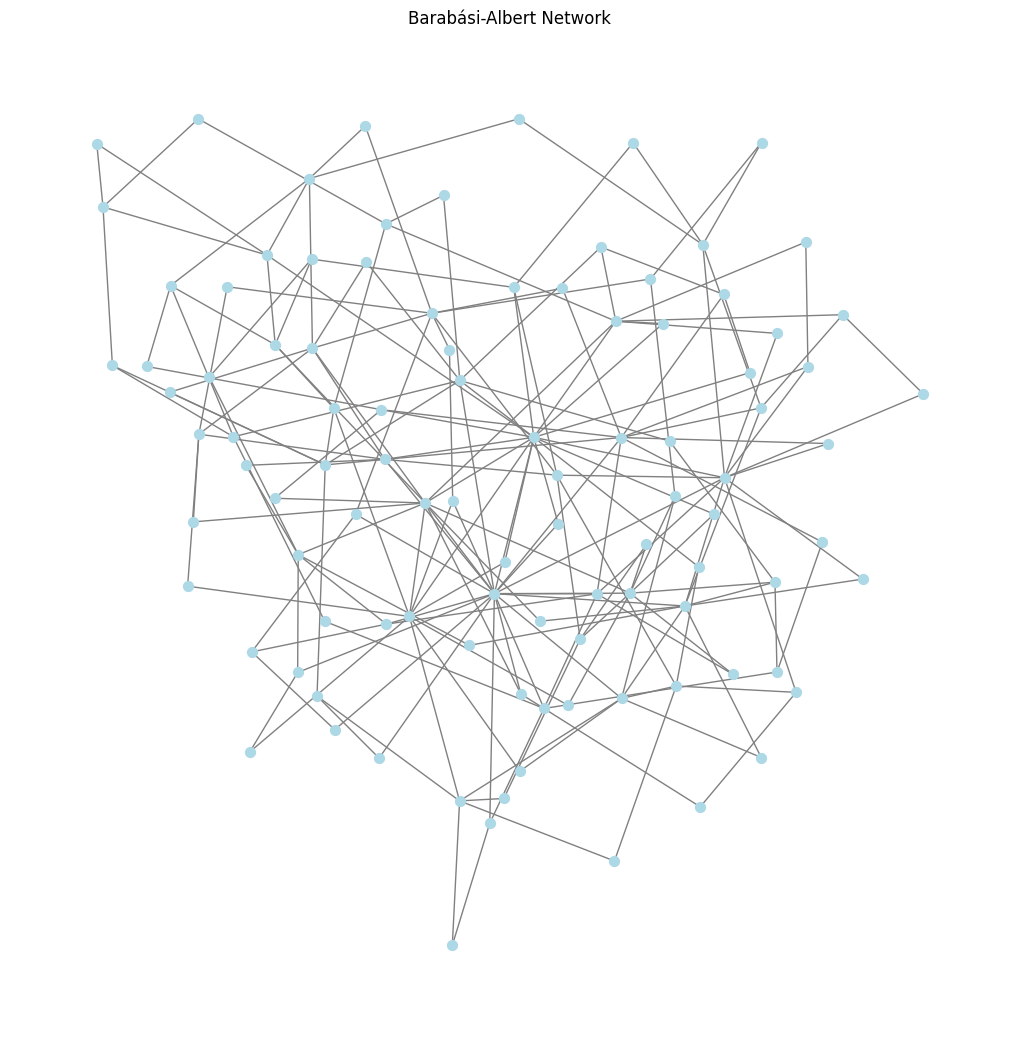

Number of nodes: 100
Number of edges: 197
Average degree: 3.94


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def barabasi_albert_graph(n, m0, m):
    """
    Generate a network using Barabási-Albert preferential attachment model
    
    Parameters:
    n: int - Final number of nodes
    m0: int - Initial number of nodes
    m: int - Number of edges to attach for each new node
    
    Returns:
    G: NetworkX graph
    """
    # Initialize graph with m0 nodes
    G = nx.complete_graph(m0)
    
    # Add remaining nodes
    for i in range(m0, n):
        # Calculate probabilities based on degree
        degrees = [d for _, d in G.degree()]
        total_degree = sum(degrees)
        probabilities = [d/total_degree for d in degrees]
        
        # Select m target nodes based on preferential attachment
        targets = np.random.choice(list(G.nodes()), size=m, replace=False, p=probabilities)
        
        # Add new node and connect to targets
        G.add_node(i)
        for target in targets:
            G.add_edge(i, target)
    
    return G

# Example usage
n = 100  # Total number of nodes
m0 = 3   # Initial number of nodes
m = 2    # Number of edges for each new node

# Generate BA network
G = barabasi_albert_graph(n, m0, m)

# Visualize the network
plt.figure(figsize=(10, 10))
nx.draw(G, node_size=50, node_color='lightblue', 
        with_labels=False, edge_color='gray')
plt.title('Barabási-Albert Network')
plt.show()

# Print some basic network statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Average degree: {sum(dict(G.degree()).values())/G.number_of_nodes():.2f}")

### Exercise 2 

Use the priviouse algorithm to create a visualization of a growing networks.

### Solution 

In [6]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def create_ba_growth_slider(max_nodes=50, m0=3, m=2):
    """
    Create an interactive BA network visualization with a time slider
    """
    # Initialize the complete graph that we'll grow
    G_complete = nx.complete_graph(m0)
    
    # Grow the network to max size and store all intermediate edges
    edge_history = []
    node_history = list(range(m0))
    
    for i in range(m0, max_nodes):
        degrees = [d for _, d in G_complete.degree()]
        total_degree = sum(degrees)
        probabilities = [d/total_degree for d in degrees]
        
        targets = np.random.choice(list(G_complete.nodes()), size=m, replace=False, p=probabilities)
        
        G_complete.add_node(i)
        node_history.append(i)
        for target in targets:
            G_complete.add_edge(i, target)
            edge_history.append((i, target))
    
    def update_graph(time):
        """Update the graph visualization based on slider value"""
        clear_output(wait=True)
        
        # Create graph up to selected time
        G = nx.Graph()
        current_nodes = node_history[:time]
        G.add_nodes_from(current_nodes)
        
        # Add edges up to current time
        current_edges = edge_history[:max(0, (time-m0)*m)]
        G.add_edges_from(current_edges)
        
        # Visualize
        plt.figure(figsize=(10, 10))
        nx.draw(G, node_size=300, node_color='lightblue', 
                with_labels=True, edge_color='gray')
        plt.title(f'Barabási-Albert Network: {time} nodes')
        plt.show()
        
        # Redisplay the slider
        display(slider)
    
    # Create the slider
    slider = widgets.IntSlider(
        value=m0,
        min=m0,
        max=max_nodes,
        step=1,
        description='Nodes:',
        continuous_update=False
    )
    
    # Create and display the interactive widget
    interactive_plot = widgets.interactive(update_graph, time=slider)
    display(interactive_plot)

# Create and display the interactive visualization
create_ba_growth_slider(max_nodes=20, m0=3, m=2)

interactive(children=(IntSlider(value=3, continuous_update=False, description='Nodes:', max=20, min=3), Output…

### Exercise 3

Plot the (averaged) histogram of the degree distribution at time t.

### Solution 

In [7]:
def create_ba_growth_analysis(max_nodes=50, m0=3, m=2, num_realizations=10):
    """
    Create interactive visualization with both network and degree distribution
    """
    def generate_degree_distributions(time):
        # Generate multiple realizations and collect degree distributions
        all_degrees = []
        for _ in range(num_realizations): # num_realizations is the number graphs we are generating with the same parameters 
            G = barabasi_albert_graph(time, m0, m)
            degrees = [d for _, d in G.degree()]
            all_degrees.extend(degrees)
        
        # Calculate degree distribution
        unique_degrees = np.unique(all_degrees)
        degree_counts = np.array([all_degrees.count(d) for d in unique_degrees])
        degree_prob = degree_counts / (len(all_degrees) * num_realizations)
        
        return unique_degrees, degree_prob

    def update_plots(time):
        clear_output(wait=True)
        
        # Create subplot figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
        
        # Plot network on left subplot
        G = barabasi_albert_graph(time, m0, m)
        nx.draw(G, ax=ax1, node_size=300, node_color='lightblue', 
                with_labels=True, edge_color='gray')
        ax1.set_title(f'BA Network: {time} nodes')
        
        # Plot degree distribution on right subplot
        degrees, prob = generate_degree_distributions(time)
        ax2.loglog(degrees, prob, 'bo-', markersize=8, label='Observed')
        ax2.set_xlabel('Degree (k)')
        ax2.set_ylabel('P(k)')
        ax2.set_title('Degree Distribution (averaged)')
        ax2.grid(True)
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Redisplay slider
        display(slider)
    
    # Create slider
    slider = widgets.IntSlider(
        value=m0,
        min=m0,
        max=max_nodes,
        step=1,
        description='Nodes:',
        continuous_update=False
    )
    
    # Create and display interactive widget
    interactive_plot = widgets.interactive(update_plots, time=slider)
    display(interactive_plot)

# Create visualization with smaller network for better visibility
create_ba_growth_analysis(max_nodes=30, m0=3, m=2, num_realizations=10)

interactive(children=(IntSlider(value=3, continuous_update=False, description='Nodes:', max=30, min=3), Output…

### Exercise 4 

Find the α coefficient for the data from the previous tasks. Does it agree with our theoretical result from the lecture?

### Solution 

In [8]:
def fit_power_law(degrees, probabilities):
    """
    Fit power law to degree distribution using linear regression on log-log data
    Returns alpha coefficient where P(k) ~ k^(-alpha)
    """
    # Convert to log scale, removing any zero probabilities
    mask = probabilities > 0
    log_degrees = np.log(degrees[mask])
    log_probs = np.log(probabilities[mask])
    
    # Linear regression on log-log data
    coeffs = np.polyfit(log_degrees, log_probs, 1)
    alpha = -coeffs[0]  # Negative slope gives alpha
    
    return alpha, coeffs

def create_ba_growth_analysis_with_alpha(max_nodes=50, m0=3, m=2, num_realizations=10):
    def generate_and_fit_distribution(time):
        # Generate multiple realizations and collect degree distributions
        all_degrees = []
        for _ in range(num_realizations):
            G = barabasi_albert_graph(time, m0, m)
            degrees = [d for _, d in G.degree()]
            all_degrees.extend(degrees)
        
        # Calculate degree distribution
        unique_degrees = np.unique(all_degrees)
        degree_counts = np.array([all_degrees.count(d) for d in unique_degrees])
        degree_prob = degree_counts / (len(all_degrees) * num_realizations)
        
        # Fit power law
        alpha, coeffs = fit_power_law(unique_degrees, degree_prob)
        
        return unique_degrees, degree_prob, alpha, coeffs

    def update_plots(time):
        clear_output(wait=True)
        
        # Create subplot figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
        
        # Plot network on left subplot
        G = barabasi_albert_graph(time, m0, m)
        nx.draw(G, ax=ax1, node_size=300, node_color='lightblue', 
                with_labels=True, edge_color='gray')
        ax1.set_title(f'BA Network: {time} nodes')
        
        # Plot degree distribution and fit on right subplot
        degrees, prob, alpha, coeffs = generate_and_fit_distribution(time)
        ax2.loglog(degrees, prob, 'bo', markersize=8, label='Observed')
        
        # Plot fitted line
        x_fit = np.logspace(np.log10(min(degrees)), np.log10(max(degrees)), 100)
        y_fit = np.exp(coeffs[1]) * x_fit**(-alpha)
        ax2.loglog(x_fit, y_fit, 'r-', label=f'Fit: α ≈ {alpha:.2f}')
        
        ax2.set_xlabel('Degree (k)')
        ax2.set_ylabel('P(k)')
        ax2.set_title('Degree Distribution with Power Law Fit')
        ax2.grid(True)
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        print(f"Power law exponent α = {alpha:.2f}")
        print("Theoretical expectation for BA model: α = 3.0")
        
        # Redisplay slider
        display(slider)
    
    # Create slider
    slider = widgets.IntSlider(
        value=m0,
        min=m0,
        max=max_nodes,
        step=1,
        description='Nodes:',
        continuous_update=False
    )
    
    # Create and display interactive widget
    interactive_plot = widgets.interactive(update_plots, time=slider)
    display(interactive_plot)

# Create visualization with analysis
create_ba_growth_analysis_with_alpha(max_nodes=100, m0=3, m=2, num_realizations=20)

interactive(children=(IntSlider(value=3, continuous_update=False, description='Nodes:', min=3), Output()), _do…

### Exercise 5

Check with simulations relation $k_{i}(t)$. Compare the predictions of the obtained formulas with the ”empirical” data from simpulations.

### Solution 

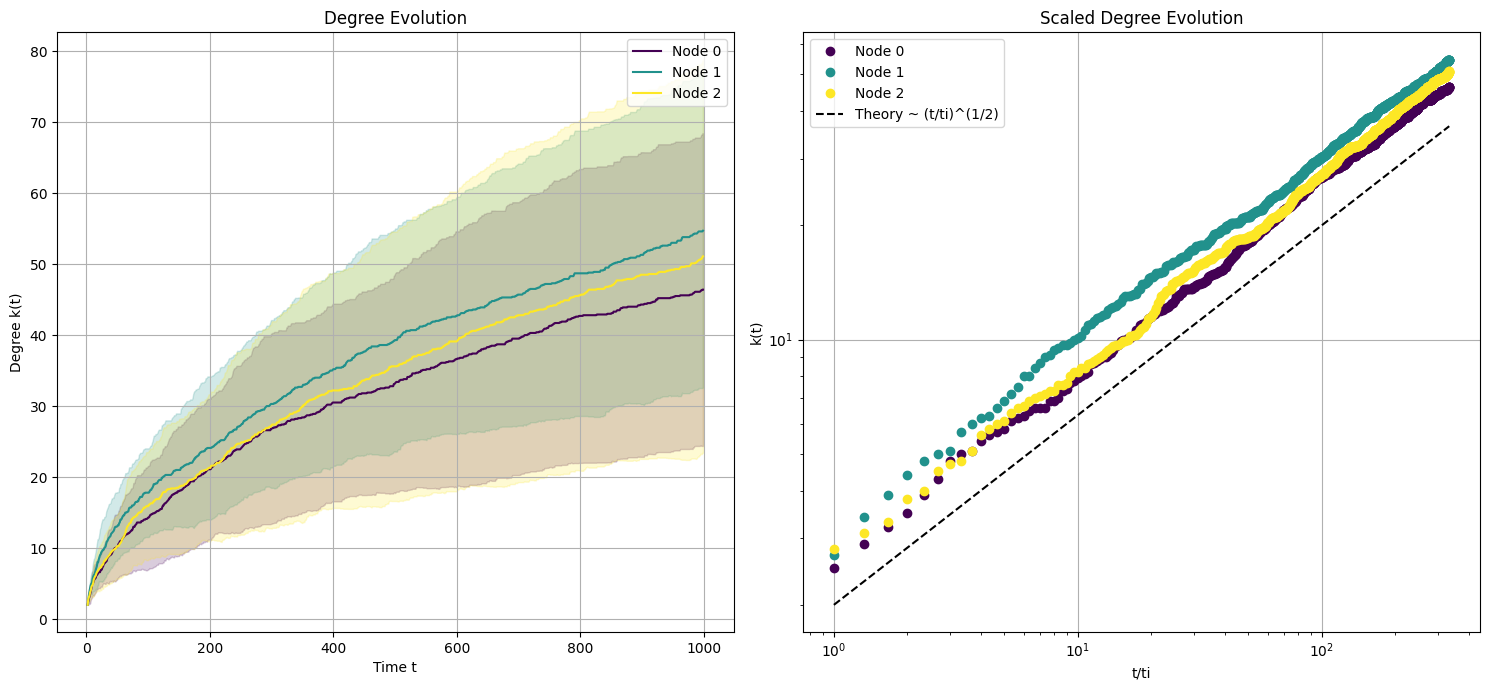

In [9]:
def track_node_degrees(n, m0, m, tracked_nodes=None):
    """
    Track the degree evolution of specific nodes over time
    
    Parameters:
    n: final number of nodes
    m0: initial nodes
    m: edges per new node
    tracked_nodes: list of nodes to track (if None, will track first m0 nodes)
    """
    if tracked_nodes is None:
        tracked_nodes = list(range(m0))
    
    # Initialize graph
    G = nx.complete_graph(m0)
    
    # Dictionary to store degree evolution
    degree_evolution = {node: [(m0-1, m0-1)] for node in tracked_nodes}
    
    # Grow network and track degrees
    for t in range(m0, n):
        degrees = [d for _, d in G.degree()]
        total_degree = sum(degrees)
        probabilities = [d/total_degree for d in degrees]
        
        targets = np.random.choice(list(G.nodes()), size=m, replace=False, p=probabilities)
        G.add_node(t)
        for target in targets:
            G.add_edge(t, target)
            
        # Record degrees of tracked nodes
        for node in tracked_nodes:
            degree_evolution[node].append((t, G.degree(node)))
    
    return degree_evolution

def plot_degree_evolution(n=1000, m0=3, m=2, num_realizations=10):
    """
    Plot degree evolution and compare with theoretical prediction
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # Track nodes from multiple realizations
    all_evolutions = []
    for _ in range(num_realizations):
        evolution = track_node_degrees(n, m0, m)
        all_evolutions.append(evolution)
    
    # Plot empirical evolution
    colors = plt.cm.viridis(np.linspace(0, 1, m0))
    for node in range(m0):
        # Average over realizations
        times = np.array([t for t, _ in all_evolutions[0][node]])
        degrees = np.zeros((num_realizations, len(times)))
        for r in range(num_realizations):
            degrees[r, :] = [d for _, d in all_evolutions[r][node]]
        mean_degrees = degrees.mean(axis=0)
        std_degrees = degrees.std(axis=0)
        
        # Plot with error bands
        ax1.plot(times, mean_degrees, '-', color=colors[node], 
                label=f'Node {node}')
        ax1.fill_between(times, mean_degrees-std_degrees, mean_degrees+std_degrees, 
                        color=colors[node], alpha=0.2)
        
        # Log-log plot
        ax2.plot(times[1:]/times[1], mean_degrees[1:], 'o', color=colors[node], 
                label=f'Node {node}')
    
    # Add theoretical prediction k(t) ~ (t/ti)^(1/2)
    t = np.linspace(1, n/m0, 100)
    theory = m * (t)**0.5
    ax2.plot(t, theory, 'k--', label='Theory ~ (t/ti)^(1/2)')
    
    # Formatting
    ax1.set_xlabel('Time t')
    ax1.set_ylabel('Degree k(t)')
    ax1.set_title('Degree Evolution')
    ax1.legend()
    ax1.grid(True)
    
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('t/ti')
    ax2.set_ylabel('k(t)')
    ax2.set_title('Scaled Degree Evolution')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Run simulation
plot_degree_evolution(n=1000, m0=3, m=2, num_realizations=10)